# CNNs for image classification

## Step 1: Data Loading and Preprocessing

### 1.1 Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

### Define Data Transformations

In [2]:
# Define training data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Define test data normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

### 1.3 Load the CIFAR-10 Dataset and Implement Checkpoints

In [3]:
data_dir = './data'

# Check if the dataset directory already exists
if not os.path.exists(data_dir):
    print("Downloading CIFAR-10 dataset...")
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_test
    )
else:
    print("Dataset already exists. Loading data...")
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=False,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=False,
        transform=transform_test
    )

Dataset already exists. Loading data...


### 1.4 Split the Data

In [4]:
torch.manual_seed(42)  # Set random seed for reproducibility

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### 1.5 Verify Data Loading and Preprocessing

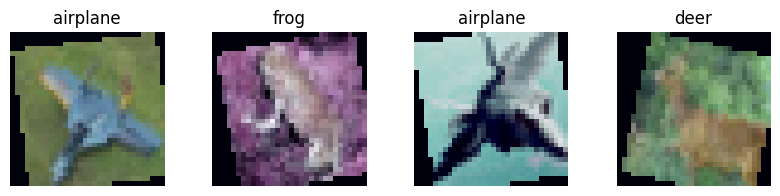

In [5]:

# Function to unnormalize, clip, and show an image
def imshow(img):
    img = img * 0.2023 + 0.4914  # Unnormalize using the mean and std deviation
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Display images with labels
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for idx, ax in enumerate(axes):
    img = images[idx]  # Select image
    img = img * 0.2023 + 0.4914  # Unnormalize
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Display image on the subplot
    ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.show()

## Model Definition and Setup

### Step 2.1: Define and Customize ResNet-18

In [6]:
# Step 2.1: Define Custom ResNet-18 for CIFAR-10
import torch.nn as nn
import torchvision.models as models

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet18, self).__init__()
        # Load the ResNet-18 architecture
        self.model = models.resnet18(pretrained=False)
        
        # Modify the initial convolution layer to fit CIFAR-10's image size
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Remove max-pooling to avoid excessive downsampling
        self.model.maxpool = nn.Identity()
        
        # Modify the final fully connected layer to match CIFAR-10's classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
resnet18_model = CustomResNet18(num_classes=10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = resnet18_model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Step 2.2: Define and Customize AlexNet

In [7]:
# Step 2.2: Define Custom AlexNet for CIFAR-10
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten feature map
        x = self.classifier(x)
        return x

# Instantiate the model
alexnet_model = CustomAlexNet(num_classes=10)
alexnet_model = alexnet_model.to(device)

### Step 2.3: Define and Customize MobileNetV2 (Fine-Tuned)

In [8]:
# Step 2.3: Define Custom MobileNetV2 for CIFAR-10
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomMobileNetV2, self).__init__()
        # Load MobileNetV2 with pretrained weights
        self.model = models.mobilenet_v2(pretrained=True)
        
        # Modify the classifier layer for CIFAR-10
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
mobilenet_model = CustomMobileNetV2(num_classes=10)
mobilenet_model = mobilenet_model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 3.1: Define Loss Function and Optimizers

In [9]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers for each model (SGD with momentum)
resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
alexnet_optimizer = optim.SGD(alexnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
mobilenet_optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

### Step 3.2: Training and Validation Loops

In [10]:
# Function to train and validate a model
def train_and_validate(model, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

    print("Training and validation complete.")

### Step 3.3: Train Each Model

In [11]:
# Train ResNet-18 model
print("Training ResNet-18...")
train_and_validate(resnet18_model, resnet18_optimizer)


Training ResNet-18...
Epoch [1/20], Train Loss: 1.7843, Train Acc: 33.72%
Epoch [1/20], Val Loss: 1.6186, Val Acc: 40.53%
Epoch [2/20], Train Loss: 1.4096, Train Acc: 48.80%
Epoch [2/20], Val Loss: 1.3067, Val Acc: 53.16%
Epoch [3/20], Train Loss: 1.1786, Train Acc: 58.01%
Epoch [3/20], Val Loss: 1.1591, Val Acc: 59.50%
Epoch [4/20], Train Loss: 1.0342, Train Acc: 63.47%
Epoch [4/20], Val Loss: 1.0900, Val Acc: 60.54%
Epoch [5/20], Train Loss: 0.9069, Train Acc: 68.19%
Epoch [5/20], Val Loss: 1.0097, Val Acc: 64.99%
Epoch [6/20], Train Loss: 0.8310, Train Acc: 70.91%
Epoch [6/20], Val Loss: 0.8659, Val Acc: 69.71%
Epoch [7/20], Train Loss: 0.7585, Train Acc: 73.21%
Epoch [7/20], Val Loss: 0.7461, Val Acc: 73.72%
Epoch [8/20], Train Loss: 0.7171, Train Acc: 74.87%
Epoch [8/20], Val Loss: 0.7729, Val Acc: 73.67%
Epoch [9/20], Train Loss: 0.6720, Train Acc: 76.35%
Epoch [9/20], Val Loss: 0.7448, Val Acc: 74.07%
Epoch [10/20], Train Loss: 0.6363, Train Acc: 77.82%
Epoch [10/20], Val Loss: 

In [12]:
# Train AlexNet model
print("Training AlexNet...")
train_and_validate(alexnet_model, alexnet_optimizer)


Training AlexNet...
Epoch [1/20], Train Loss: 2.2353, Train Acc: 14.81%
Epoch [1/20], Val Loss: 2.0303, Val Acc: 23.85%
Epoch [2/20], Train Loss: 1.9280, Train Acc: 26.83%
Epoch [2/20], Val Loss: 1.7834, Val Acc: 33.98%
Epoch [3/20], Train Loss: 1.7155, Train Acc: 35.90%
Epoch [3/20], Val Loss: 1.6706, Val Acc: 38.87%
Epoch [4/20], Train Loss: 1.5865, Train Acc: 41.01%
Epoch [4/20], Val Loss: 1.4814, Val Acc: 46.43%
Epoch [5/20], Train Loss: 1.4409, Train Acc: 47.33%
Epoch [5/20], Val Loss: 1.3308, Val Acc: 51.45%
Epoch [6/20], Train Loss: 1.3383, Train Acc: 51.19%
Epoch [6/20], Val Loss: 1.2789, Val Acc: 54.10%
Epoch [7/20], Train Loss: 1.2527, Train Acc: 54.51%
Epoch [7/20], Val Loss: 1.1625, Val Acc: 57.94%
Epoch [8/20], Train Loss: 1.1600, Train Acc: 58.12%
Epoch [8/20], Val Loss: 1.0707, Val Acc: 61.38%
Epoch [9/20], Train Loss: 1.0839, Train Acc: 61.31%
Epoch [9/20], Val Loss: 0.9687, Val Acc: 64.88%
Epoch [10/20], Train Loss: 1.0177, Train Acc: 63.62%
Epoch [10/20], Val Loss: 0.

In [13]:
# Train MobileNetV2 model
print("Training MobileNetV2...")
train_and_validate(mobilenet_model, mobilenet_optimizer)

Training MobileNetV2...
Epoch [1/20], Train Loss: 1.4245, Train Acc: 50.01%
Epoch [1/20], Val Loss: 1.1006, Val Acc: 60.64%
Epoch [2/20], Train Loss: 1.0288, Train Acc: 64.16%
Epoch [2/20], Val Loss: 0.9558, Val Acc: 66.08%
Epoch [3/20], Train Loss: 0.9340, Train Acc: 67.65%
Epoch [3/20], Val Loss: 0.8903, Val Acc: 68.72%
Epoch [4/20], Train Loss: 0.8667, Train Acc: 69.86%
Epoch [4/20], Val Loss: 0.8442, Val Acc: 70.12%
Epoch [5/20], Train Loss: 0.8359, Train Acc: 71.01%
Epoch [5/20], Val Loss: 0.9321, Val Acc: 67.82%
Epoch [6/20], Train Loss: 0.8089, Train Acc: 72.17%
Epoch [6/20], Val Loss: 0.8043, Val Acc: 71.59%
Epoch [7/20], Train Loss: 0.7624, Train Acc: 73.68%
Epoch [7/20], Val Loss: 0.7870, Val Acc: 72.13%
Epoch [8/20], Train Loss: 0.7496, Train Acc: 74.11%
Epoch [8/20], Val Loss: 0.7382, Val Acc: 74.39%
Epoch [9/20], Train Loss: 0.7274, Train Acc: 74.95%
Epoch [9/20], Val Loss: 0.7565, Val Acc: 73.30%
Epoch [10/20], Train Loss: 0.7127, Train Acc: 75.21%
Epoch [10/20], Val Loss

## Step 4.1: Model Evaluation on Test Set

In [14]:
# Function to evaluate model on test data
def evaluate_model_on_test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    return test_acc

# Evaluate each model
print("Evaluating models on the test set...")
resnet18_test_acc = evaluate_model_on_test(resnet18_model, test_loader)
print(f"ResNet-18 Test Accuracy: {resnet18_test_acc:.2f}%")

alexnet_test_acc = evaluate_model_on_test(alexnet_model, test_loader)
print(f"AlexNet Test Accuracy: {alexnet_test_acc:.2f}%")

mobilenet_test_acc = evaluate_model_on_test(mobilenet_model, test_loader)
print(f"MobileNetV2 Test Accuracy: {mobilenet_test_acc:.2f}%")

Evaluating models on the test set...
ResNet-18 Test Accuracy: 82.86%
AlexNet Test Accuracy: 80.35%
MobileNetV2 Test Accuracy: 80.34%


In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_metrics(train_metrics, val_metrics, metric_name, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.title(f'{model_name} {metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming training and validation losses and accuracies have been stored during training
# Example of usage for plotting:
# plot_metrics(resnet18_train_loss, resnet18_val_loss, 'Loss', 'ResNet-18')
# plot_metrics(resnet18_train_acc, resnet18_val_acc, 'Accuracy', 'ResNet-18')

### Step 4.2: Generate Confusion Matrices for Each Model

Generating confusion matrix for ResNet-18...


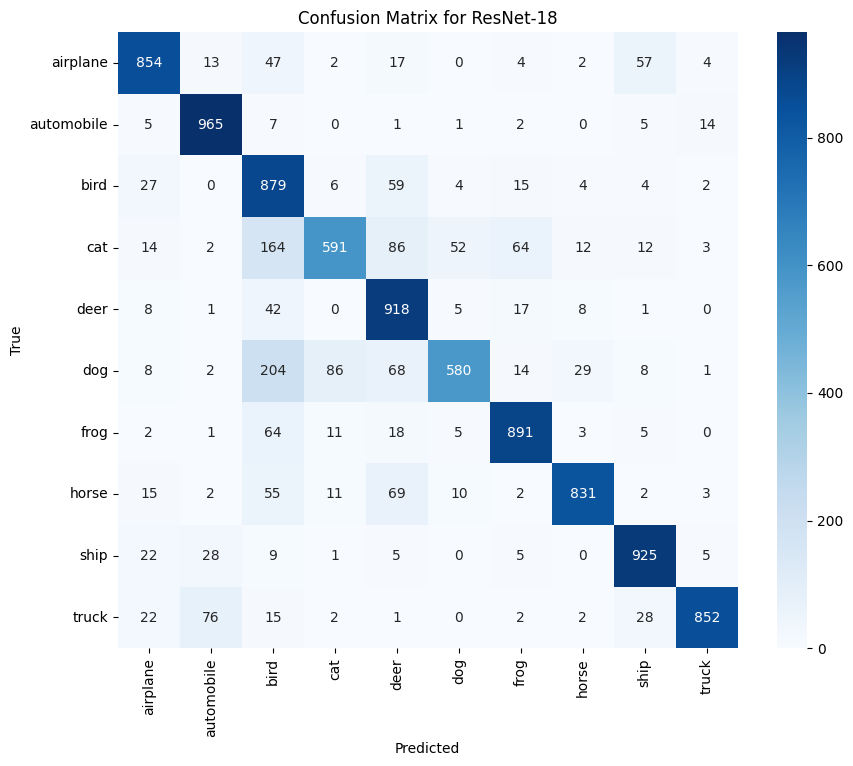

Generating confusion matrix for AlexNet...


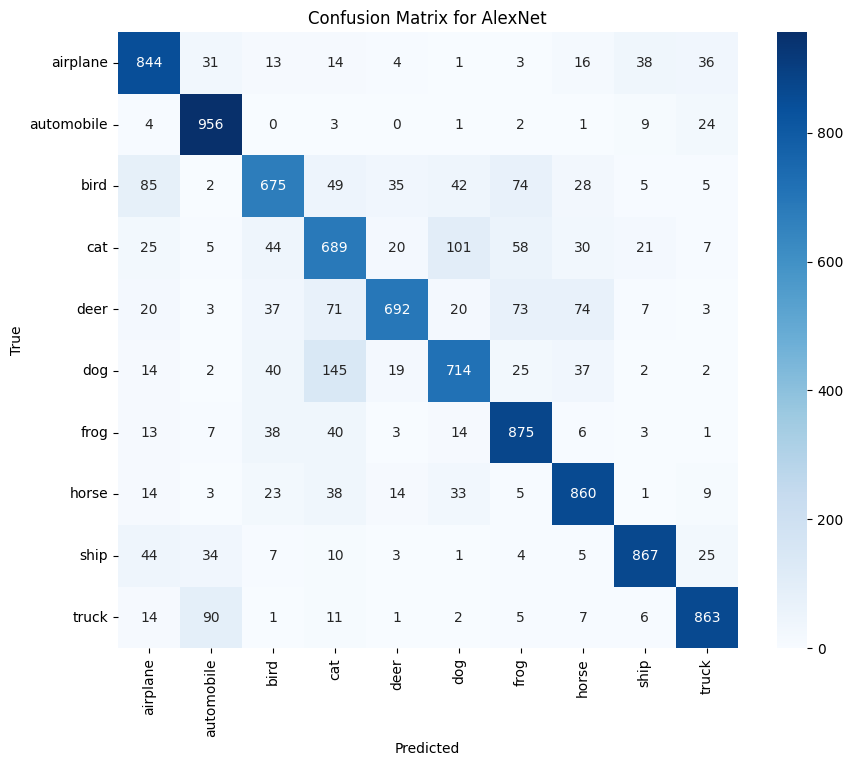

Generating confusion matrix for MobileNetV2...


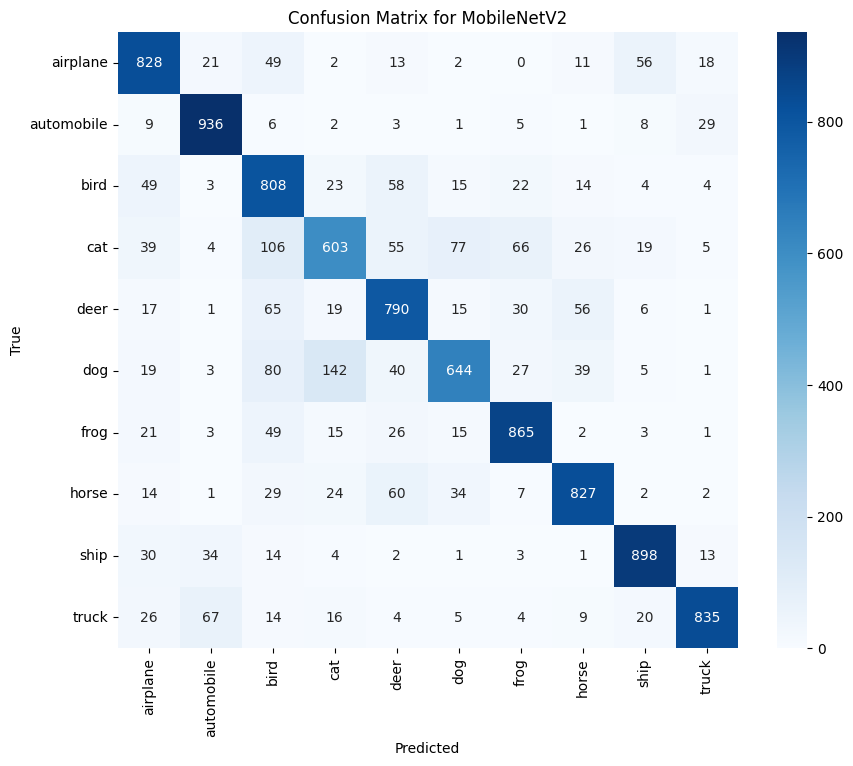

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Function to compute and plot a confusion matrix
def plot_confusion_matrix(model, test_loader, model_name):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create a confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrices for each model
print("Generating confusion matrix for ResNet-18...")
plot_confusion_matrix(resnet18_model, test_loader, 'ResNet-18')

print("Generating confusion matrix for AlexNet...")
plot_confusion_matrix(alexnet_model, test_loader, 'AlexNet')

print("Generating confusion matrix for MobileNetV2...")
plot_confusion_matrix(mobilenet_model, test_loader, 'MobileNetV2')

### Step 4.3: Visualize Training and Validation Curves

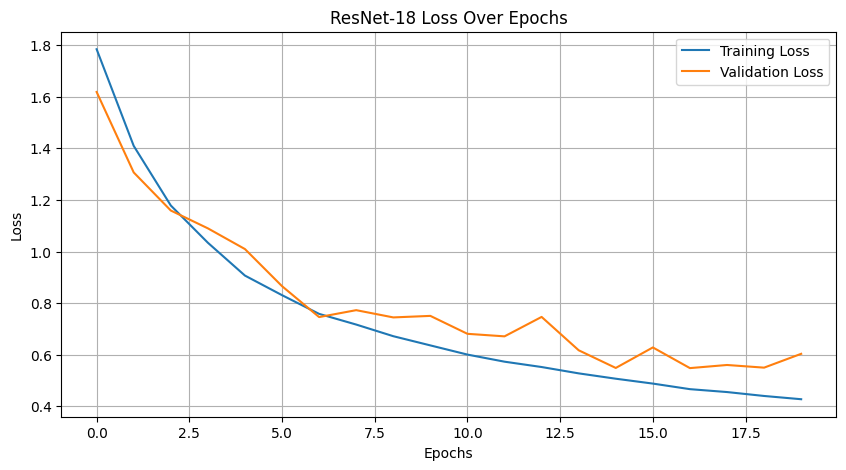

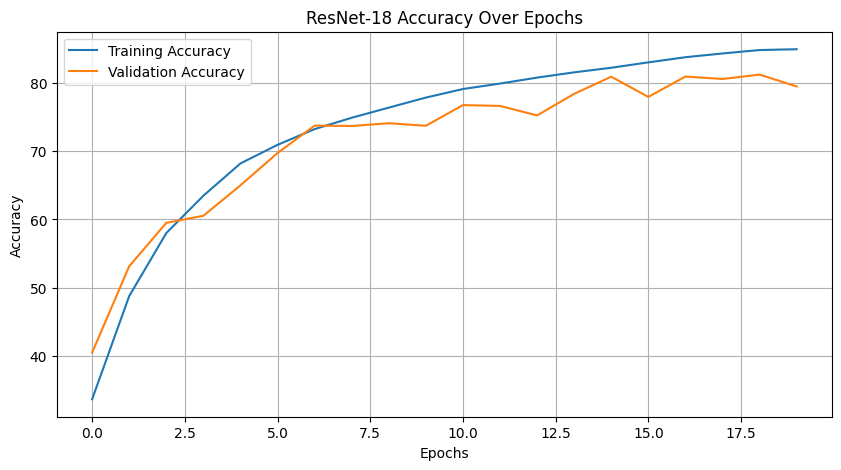

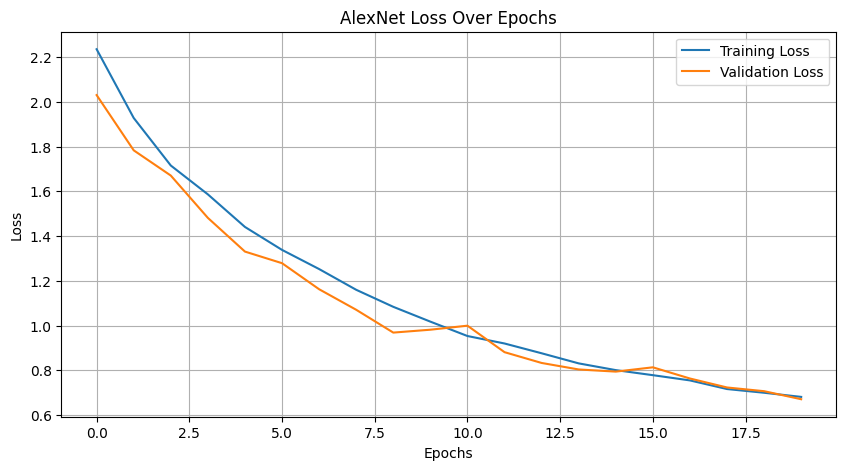

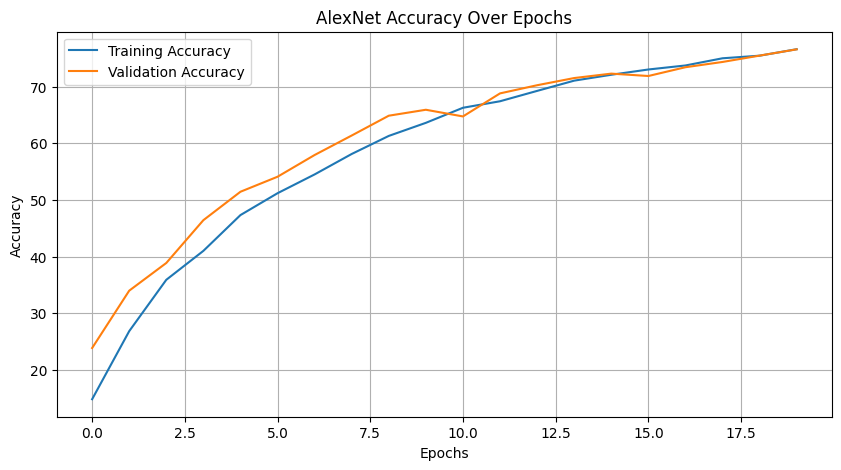

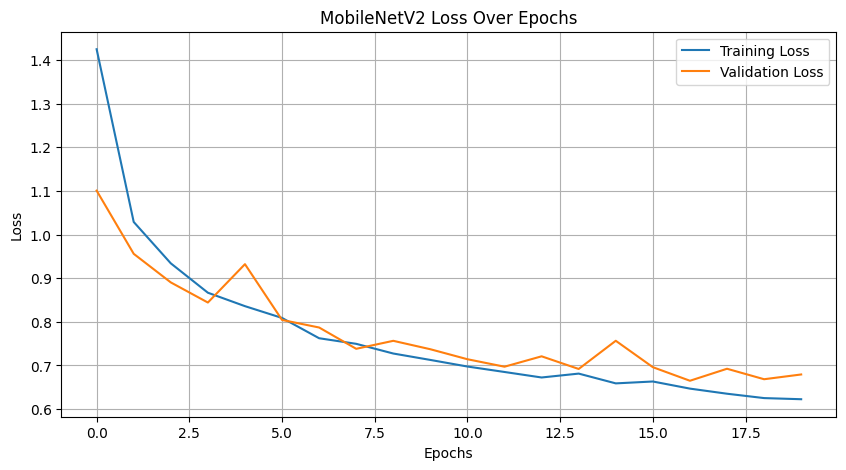

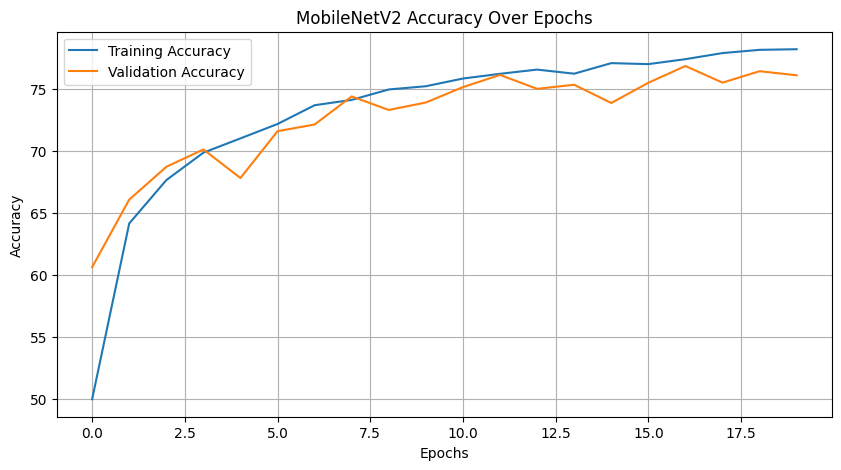

In [18]:
import matplotlib.pyplot as plt

# Placeholder training and validation loss/accuracy lists for visualization
# Replace these with actual values collected during training
resnet18_train_loss = [1.7843, 1.4096, 1.1786, 1.0342, 0.9069, 0.8310, 0.7585, 0.7171, 0.6720, 0.6363, 0.6007, 0.5732, 0.5525, 0.5279, 0.5072, 0.4883, 0.4667, 0.4555, 0.4403, 0.4277]
resnet18_val_loss = [1.6186, 1.3067, 1.1591, 1.0900, 1.0097, 0.8659, 0.7461, 0.7729, 0.7448, 0.7507, 0.6812, 0.6714, 0.7467, 0.6174, 0.5489, 0.6284, 0.5483, 0.5604, 0.5501, 0.6037]
resnet18_train_acc = [33.72, 48.80, 58.01, 63.47, 68.19, 70.91, 73.21, 74.87, 76.35, 77.82, 79.07, 79.87, 80.74, 81.51, 82.18, 82.97, 83.72, 84.27, 84.77, 84.89]
resnet18_val_acc = [40.53, 53.16, 59.50, 60.54, 64.99, 69.71, 73.72, 73.67, 74.07, 73.70, 76.72, 76.60, 75.21, 78.37, 80.87, 77.92, 80.89, 80.54, 81.18, 79.44]

alexnet_train_loss = [2.2353, 1.9280, 1.7155, 1.5865, 1.4409, 1.3383, 1.2527, 1.1600, 1.0839, 1.0177, 0.9534, 0.9200, 0.8763, 0.8311, 0.8010, 0.7784, 0.7550, 0.7164, 0.6998, 0.6813]
alexnet_val_loss = [2.0303, 1.7834, 1.6706, 1.4814, 1.3308, 1.2789, 1.1625, 1.0707, 0.9687, 0.9816, 0.9996, 0.8812, 0.8330, 0.8039, 0.7943, 0.8135, 0.7635, 0.7234, 0.7068, 0.6709]
alexnet_train_acc = [14.81, 26.83, 35.90, 41.01, 47.33, 51.19, 54.51, 58.12, 61.31, 63.62, 66.28, 67.43, 69.26, 71.07, 72.11, 73.04, 73.75, 75.02, 75.48, 76.62]
alexnet_val_acc = [23.85, 33.98, 38.87, 46.43, 51.45, 54.10, 57.94, 61.38, 64.88, 65.93, 64.75, 68.82, 70.26, 71.53, 72.31, 71.89, 73.44, 74.37, 75.49, 76.60]

mobilenet_train_loss = [1.4245, 1.0288, 0.9340, 0.8667, 0.8359, 0.8089, 0.7624, 0.7496, 0.7274, 0.7127, 0.6976, 0.6851, 0.6725, 0.6814, 0.6590, 0.6633, 0.6470, 0.6353, 0.6253, 0.6227]
mobilenet_val_loss = [1.1006, 0.9558, 0.8903, 0.8442, 0.9321, 0.8043, 0.7870, 0.7382, 0.7565, 0.7372, 0.7143, 0.6972, 0.7210, 0.6920, 0.7566, 0.6961, 0.6650, 0.6925, 0.6685, 0.6794]
mobilenet_train_acc = [50.01, 64.16, 67.65, 69.86, 71.01, 72.17, 73.68, 74.11, 74.95, 75.21, 75.83, 76.21, 76.55, 76.22, 77.07, 76.99, 77.39, 77.88, 78.14, 78.19]
mobilenet_val_acc = [60.64, 66.08, 68.72, 70.12, 67.82, 71.59, 72.13, 74.39, 73.30, 73.90, 75.14, 76.12, 75.00, 75.33, 73.86, 75.49, 76.84, 75.50, 76.42, 76.09]

# Plot metrics for each model
def plot_metrics(train_metrics, val_metrics, metric_name, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.title(f'{model_name} {metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for ResNet-18
plot_metrics(resnet18_train_loss, resnet18_val_loss, 'Loss', 'ResNet-18')
plot_metrics(resnet18_train_acc, resnet18_val_acc, 'Accuracy', 'ResNet-18')

# Plot for AlexNet
plot_metrics(alexnet_train_loss, alexnet_val_loss, 'Loss', 'AlexNet')
plot_metrics(alexnet_train_acc, alexnet_val_acc, 'Accuracy', 'AlexNet')

# Plot for MobileNetV2
plot_metrics(mobilenet_train_loss, mobilenet_val_loss, 'Loss', 'MobileNetV2')
plot_metrics(mobilenet_train_acc, mobilenet_val_acc, 'Accuracy', 'MobileNetV2')


#### Calculate Per-Class Precision, Recall, and F1-Score

In [19]:
from sklearn.metrics import classification_report

# Function to evaluate and print per-class precision, recall, and F1-score
def per_class_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print the classification report for per-class metrics
    report = classification_report(all_labels, all_preds, target_names=classes)
    print(report)
    return report

# Evaluate and print per-class metrics for each model
print("ResNet-18 Per-Class Metrics:")
resnet18_report = per_class_metrics(resnet18_model, test_loader)

print("\nAlexNet Per-Class Metrics:")
alexnet_report = per_class_metrics(alexnet_model, test_loader)

print("\nMobileNetV2 Per-Class Metrics:")
mobilenet_report = per_class_metrics(mobilenet_model, test_loader)

ResNet-18 Per-Class Metrics:
              precision    recall  f1-score   support

    airplane       0.87      0.85      0.86      1000
  automobile       0.89      0.96      0.92      1000
        bird       0.59      0.88      0.71      1000
         cat       0.83      0.59      0.69      1000
        deer       0.74      0.92      0.82      1000
         dog       0.88      0.58      0.70      1000
        frog       0.88      0.89      0.88      1000
       horse       0.93      0.83      0.88      1000
        ship       0.88      0.93      0.90      1000
       truck       0.96      0.85      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.85      0.83      0.83     10000
weighted avg       0.85      0.83      0.83     10000


AlexNet Per-Class Metrics:
              precision    recall  f1-score   support

    airplane       0.78      0.84      0.81      1000
  automobile       0.84      0.96      0.90      1000
        bird       0.

#### Visualize Training/Validation Loss and Accuracy Curves

In [ ]:
# Plotting function for training/validation curves
def plot_training_curves(training_metrics, validation_metrics, metric_name='Accuracy'):
    epochs = range(1, len(training_metrics) + 1)
    plt.plot(epochs, training_metrics, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, validation_metrics, 'ro-', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for accuracy curves (assuming train_acc_list and val_acc_list are available)
plot_training_curves(train_acc_list, val_acc_list, metric_name='Accuracy')

### Citation
Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.